In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
import seaborn as sns
import IPython.display as ipd
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

In [3]:
# Create a shortcut direction to access easily
general_path = '/Users/user/Documents/Đồ án tốt nghiệp/Music Data/Data'

In [4]:
# Import data
audio = pd.read_csv('Combined_data_audio.csv')
audio.head()

filename  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0  blues.00000.wav         -0.376549         0.303461 -0.183594 -0.142260   
1  blues.00001.wav         -0.489015         1.048257 -0.636506 -0.256053   
2  blues.00002.wav         -0.210458        -0.113159  0.415474 -0.162509   
3  blues.00003.wav          0.293949         0.930834 -0.040044  0.740006   
4  blues.00004.wav         -0.886038         0.193892 -0.694891 -0.273434   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0               -0.489905              -0.803072                -0.385229   
1               -0.847389              -0.248847                -0.314757   
2               -0.815530              -0.742952                -0.875908   
3               -1.494926              -0.680140                -1.167313   
4               -0.418352              -0.321933                -0.875003   

   spectral_bandwidth_var  rolloff_mean  ...  chroma_cqt_var  \
0               -0.557901     -0.387112  ...       -0.958410   
1                0.426392     -0.551258  ...       -0.628375   
2               -0.631965     -0.878024  ...       -0.544850   
3                0.061768     -1.429327  ...        0.437271   
4               -0.538190     -0.532462  ...        0.030965   

   chroma_cens_mean  chroma_cens_var  spectral_contrast_mean  \
0          0.928919        -0.967870               -0.121318   
1          0.497337        -0.481392               -0.053920   
2          0.561751        -0.552718                0.632285   
3         -0.853148         0.910487                0.284422   
4          0.441511        -0.419939                0.302495   

   spectral_contrast_var  spectral_flatness_mean  spectral_flatness_var  \
0               1.043437               -0.625217              -0.456503   
1               0.691727               -0.710876              -0.459329   
2               1.019261               -0.697904              -0.464424   
3               0.515012               -0.763175              -0.467944   
4               0.499250               -0.674283              -0.461211   

   tonnetz_mean  tonnetz_var  label  
0     -0.045060    -0.710316  blues  
1      0.806544    -0.686788  blues  
2      0.617224    -0.294641  blues  
3      0.706229     0.206259  blues  
4     -1.132454    -0.321003  blues  

[5 rows x 69 columns]

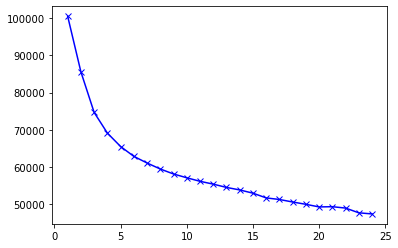

In [5]:
# Find the optimal n_clusters
feature_df = audio.iloc[:,1:-1]
feature_np = feature_df.to_numpy()
sum_distances = []

# Loop through k values from 1 to 25 to find the smallest Inertia score
K = range(1,25)
for k in K:
    k_means = KMeans(n_clusters=k, n_init=10, random_state=2)
    k_means.fit(feature_np)
    sum_distances.append(k_means.inertia_)

# Plot the results for visualization    
plt.plot(K, sum_distances, 'bx-')
plt.show()

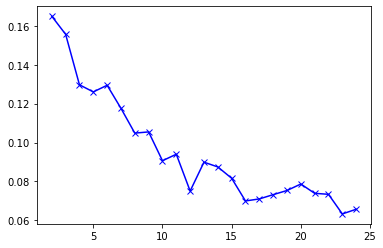

In [6]:
# Loop through k values from 2 to 25 to find the highest Silhouette score 
silhouette = []

K = range(2,25)
for k in K:
    k_means = KMeans(n_clusters=k, n_init=10, random_state=3)
    k_means.fit(feature_np)
    cluster_label = k_means.predict(feature_np)
    silhouette.append(silhouette_score(feature_np, k_means.labels_))

# Plot the results for visualization    
plt.plot(K, silhouette, 'bx-')
plt.show()

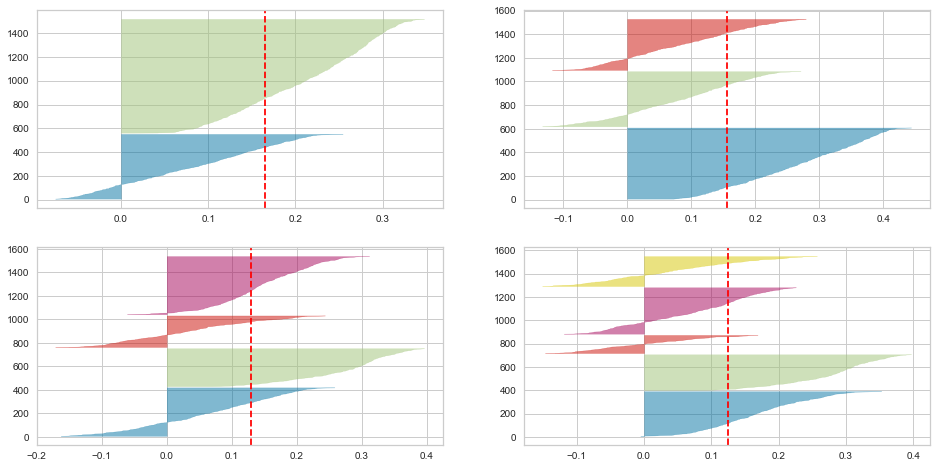

In [7]:
# To make sense the best k for model, visualize another chart for choosing k
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(16,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(feature_np)

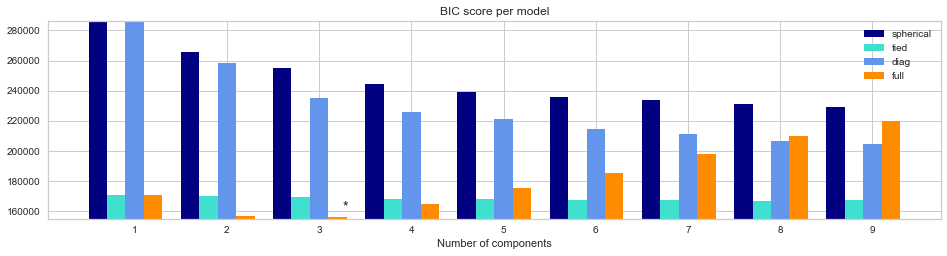

In [8]:
'''To choose components for GMM model, 
using BIC score for each covariance to find the best k values'''

import itertools
from scipy import linalg

bic = []
n_components_range = range(1, 10)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components, 
                              covariance_type=cv_type, random_state=2)
        gmm.fit(feature_np)
        bic.append(gmm.bic(feature_np))


bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
bars = []
# Plot the BIC scores
plt.figure(figsize=(16, 8))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)


In [9]:
# This codes aim create a BIC score table to apply for Recommendation Website
import itertools
from scipy import linalg

n_components_range = range(1, 10)
cv_types = ['spherical', 'tied', 'diag', 'full']
spherical, tied, diag, full = pd.DataFrame(columns=['spherical']),pd.DataFrame(columns=['tied']),pd.DataFrame(columns=['diag']),pd.DataFrame(columns=['full'])
for cv_type in cv_types:
    for n_components in n_components_range:
                # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components, 
                              covariance_type=cv_type, random_state=2)
        gmm.fit(feature_np)
        if cv_type == "spherical":
            spherical = spherical.append({cv_type: gmm.bic(feature_np)}, ignore_index=True)
        elif cv_type == "tied":
            tied = tied.append({cv_type: gmm.bic(feature_np)}, ignore_index=True)
        elif cv_type == "diag":
            diag = diag.append({cv_type: gmm.bic(feature_np)}, ignore_index=True)
        else:
            full = full.append({cv_type: gmm.bic(feature_np)}, ignore_index=True)

# Concat dataframes at one
bic_score = pd.concat([spherical, tied, diag, full], axis=1)
bic_score['k'] = n_components_range

In [10]:
# Training K-means model after choosing suitable k value
k_means = KMeans(n_clusters=3, n_init=10, random_state=1)
k_means.fit(feature_np)
result_km = k_means.predict(feature_np)

In [11]:
# Training GMM model after choosing suitable k value
gmm = GaussianMixture(n_components=3, n_init=10, random_state=1, covariance_type='full')
gmm.fit(feature_np)
result_gmm = gmm.predict(feature_np)

In [12]:
# Merge the results of GMM and K-means models into a original dataset
name = audio[['filename']]
final = pd.concat([name,feature_df], axis=1)
final['cluster_km'] = result_km
final['cluster_gmm'] = result_gmm
final.head()

filename  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0  blues.00000.wav         -0.376549         0.303461 -0.183594 -0.142260   
1  blues.00001.wav         -0.489015         1.048257 -0.636506 -0.256053   
2  blues.00002.wav         -0.210458        -0.113159  0.415474 -0.162509   
3  blues.00003.wav          0.293949         0.930834 -0.040044  0.740006   
4  blues.00004.wav         -0.886038         0.193892 -0.694891 -0.273434   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0               -0.489905              -0.803072                -0.385229   
1               -0.847389              -0.248847                -0.314757   
2               -0.815530              -0.742952                -0.875908   
3               -1.494926              -0.680140                -1.167313   
4               -0.418352              -0.321933                -0.875003   

   spectral_bandwidth_var  rolloff_mean  ...  chroma_cens_mean  \
0               -0.557901     -0.387112  ...          0.928919   
1                0.426392     -0.551258  ...          0.497337   
2               -0.631965     -0.878024  ...          0.561751   
3                0.061768     -1.429327  ...         -0.853148   
4               -0.538190     -0.532462  ...          0.441511   

   chroma_cens_var  spectral_contrast_mean  spectral_contrast_var  \
0        -0.967870               -0.121318               1.043437   
1        -0.481392               -0.053920               0.691727   
2        -0.552718                0.632285               1.019261   
3         0.910487                0.284422               0.515012   
4        -0.419939                0.302495               0.499250   

   spectral_flatness_mean  spectral_flatness_var  tonnetz_mean  tonnetz_var  \
0               -0.625217              -0.456503     -0.045060    -0.710316   
1               -0.710876              -0.459329      0.806544    -0.686788   
2               -0.697904              -0.464424      0.617224    -0.294641   
3               -0.763175              -0.467944      0.706229     0.206259   
4               -0.674283              -0.461211     -1.132454    -0.321003   

   cluster_km  cluster_gmm  
0           0            0  
1           2            2  
2           0            0  
3           2            2  
4           2            2  

[5 rows x 70 columns]

In [13]:
# Set filename to index
final.set_index('filename', inplace=True)
final.head()

chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
filename                                                                 
blues.00000.wav         -0.376549         0.303461 -0.183594 -0.142260   
blues.00001.wav         -0.489015         1.048257 -0.636506 -0.256053   
blues.00002.wav         -0.210458        -0.113159  0.415474 -0.162509   
blues.00003.wav          0.293949         0.930834 -0.040044  0.740006   
blues.00004.wav         -0.886038         0.193892 -0.694891 -0.273434   

                 spectral_centroid_mean  spectral_centroid_var  \
filename                                                         
blues.00000.wav               -0.489905              -0.803072   
blues.00001.wav               -0.847389              -0.248847   
blues.00002.wav               -0.815530              -0.742952   
blues.00003.wav               -1.494926              -0.680140   
blues.00004.wav               -0.418352              -0.321933   

                 spectral_bandwidth_mean  spectral_bandwidth_var  \
filename                                                           
blues.00000.wav                -0.385229               -0.557901   
blues.00001.wav                -0.314757                0.426392   
blues.00002.wav                -0.875908               -0.631965   
blues.00003.wav                -1.167313                0.061768   
blues.00004.wav                -0.875003               -0.538190   

                 rolloff_mean  rolloff_var  ...  chroma_cens_mean  \
filename                                    ...                     
blues.00000.wav     -0.387112    -0.667770  ...          0.928919   
blues.00001.wav     -0.551258     0.615135  ...          0.497337   
blues.00002.wav     -0.878024    -0.740350  ...          0.561751   
blues.00003.wav     -1.429327    -0.302192  ...         -0.853148   
blues.00004.wav     -0.532462    -0.252898  ...          0.441511   

                 chroma_cens_var  spectral_contrast_mean  \
filename                                                   
blues.00000.wav        -0.967870               -0.121318   
blues.00001.wav        -0.481392               -0.053920   
blues.00002.wav        -0.552718                0.632285   
blues.00003.wav         0.910487                0.284422   
blues.00004.wav        -0.419939                0.302495   

                 spectral_contrast_var  spectral_flatness_mean  \
filename                                                         
blues.00000.wav               1.043437               -0.625217   
blues.00001.wav               0.691727               -0.710876   
blues.00002.wav               1.019261               -0.697904   
blues.00003.wav               0.515012               -0.763175   
blues.00004.wav               0.499250               -0.674283   

                 spectral_flatness_var  tonnetz_mean  tonnetz_var  cluster_km  \
filename                                                                        
blues.00000.wav              -0.456503     -0.045060    -0.710316           0   
blues.00001.wav              -0.459329      0.806544    -0.686788           2   
blues.00002.wav              -0.464424      0.617224    -0.294641           0   
blues.00003.wav              -0.467944      0.706229     0.206259           2   
blues.00004.wav              -0.461211     -1.132454    -0.321003           2   

                 cluster_gmm  
filename                      
blues.00000.wav            0  
blues.00001.wav            2  
blues.00002.wav            0  
blues.00003.wav            2  
blues.00004.wav            2  

[5 rows x 69 columns]

In [14]:
# Calculate the cosine similarity of each song with the others
from sklearn.metrics.pairwise import cosine_similarity

# Create a new dataframe without the clusters
similar = final.iloc[:,:-2]
# Cosine Similarity
similarity = cosine_similarity(similar)

# Convert into a dataframe
sim_df_labels = pd.DataFrame(similarity)
sim_df = sim_df_labels.set_index(similar.index)
sim_df.columns = similar.index

sim_df.head()

filename         blues.00000.wav  blues.00001.wav  blues.00002.wav  \
filename                                                             
blues.00000.wav         1.000000         0.269704         0.619497   
blues.00001.wav         0.269704         1.000000         0.080522   
blues.00002.wav         0.619497         0.080522         1.000000   
blues.00003.wav         0.120617         0.470183         0.178229   
blues.00004.wav         0.149423         0.111399         0.427843   

filename         blues.00003.wav  blues.00004.wav  blues.00005.wav  \
filename                                                             
blues.00000.wav         0.120617         0.149423        -0.229823   
blues.00001.wav         0.470183         0.111399         0.301917   
blues.00002.wav         0.178229         0.427843         0.000037   
blues.00003.wav         1.000000         0.079591         0.203048   
blues.00004.wav         0.079591         1.000000         0.595293   

filename         blues.00006.wav  blues.00007.wav  blues.00008.wav  \
filename                                                             
blues.00000.wav        -0.211953        -0.123227         0.712951   
blues.00001.wav         0.251582         0.362614         0.303717   
blues.00002.wav        -0.024650         0.116997         0.572420   
blues.00003.wav         0.324108         0.331487         0.279976   
blues.00004.wav         0.466612         0.613713         0.123638   

filename         blues.00009.wav  ...  rock.00140.mp3  rock.00141.mp3  \
filename                          ...                                   
blues.00000.wav        -0.029077  ...        0.126341        0.017759   
blues.00001.wav         0.403016  ...       -0.133006       -0.187356   
blues.00002.wav        -0.037286  ...       -0.004064        0.119948   
blues.00003.wav         0.368824  ...       -0.321160        0.168403   
blues.00004.wav         0.465221  ...       -0.033862       -0.141384   

filename         rock.00142.mp3  rock.00143.mp3  rock.00144.mp3  \
filename                                                          
blues.00000.wav        0.117018       -0.396575        0.231954   
blues.00001.wav       -0.042899        0.168907       -0.392635   
blues.00002.wav        0.172183       -0.124249        0.123487   
blues.00003.wav        0.362121        0.377910       -0.149221   
blues.00004.wav       -0.258708       -0.038095       -0.276885   

filename         rock.00145.mp3  rock.00146.mp3  rock.00147.mp3  \
filename                                                          
blues.00000.wav        0.275912        0.335191        0.280780   
blues.00001.wav       -0.268800       -0.297781       -0.197900   
blues.00002.wav        0.067773        0.436826        0.531431   
blues.00003.wav       -0.152504        0.323979       -0.037600   
blues.00004.wav       -0.354307        0.069994        0.390730   

filename         rock.00148.mp3  rock.00149.mp3  
filename                                         
blues.00000.wav        0.335148        0.292680  
blues.00001.wav       -0.276845       -0.309337  
blues.00002.wav        0.488140       -0.048195  
blues.00003.wav        0.260945       -0.229880  
blues.00004.wav       -0.020580       -0.477579  

[5 rows x 1500 columns]

In [15]:
# Add the clusters of K-means and GMM models back to cosine similarity dataset
sim_df['cluster_km'] = result_km
sim_df['cluster_gmm'] = result_gmm
sim_df.head()

filename         blues.00000.wav  blues.00001.wav  blues.00002.wav  \
filename                                                             
blues.00000.wav         1.000000         0.269704         0.619497   
blues.00001.wav         0.269704         1.000000         0.080522   
blues.00002.wav         0.619497         0.080522         1.000000   
blues.00003.wav         0.120617         0.470183         0.178229   
blues.00004.wav         0.149423         0.111399         0.427843   

filename         blues.00003.wav  blues.00004.wav  blues.00005.wav  \
filename                                                             
blues.00000.wav         0.120617         0.149423        -0.229823   
blues.00001.wav         0.470183         0.111399         0.301917   
blues.00002.wav         0.178229         0.427843         0.000037   
blues.00003.wav         1.000000         0.079591         0.203048   
blues.00004.wav         0.079591         1.000000         0.595293   

filename         blues.00006.wav  blues.00007.wav  blues.00008.wav  \
filename                                                             
blues.00000.wav        -0.211953        -0.123227         0.712951   
blues.00001.wav         0.251582         0.362614         0.303717   
blues.00002.wav        -0.024650         0.116997         0.572420   
blues.00003.wav         0.324108         0.331487         0.279976   
blues.00004.wav         0.466612         0.613713         0.123638   

filename         blues.00009.wav  ...  rock.00142.mp3  rock.00143.mp3  \
filename                          ...                                   
blues.00000.wav        -0.029077  ...        0.117018       -0.396575   
blues.00001.wav         0.403016  ...       -0.042899        0.168907   
blues.00002.wav        -0.037286  ...        0.172183       -0.124249   
blues.00003.wav         0.368824  ...        0.362121        0.377910   
blues.00004.wav         0.465221  ...       -0.258708       -0.038095   

filename         rock.00144.mp3  rock.00145.mp3  rock.00146.mp3  \
filename                                                          
blues.00000.wav        0.231954        0.275912        0.335191   
blues.00001.wav       -0.392635       -0.268800       -0.297781   
blues.00002.wav        0.123487        0.067773        0.436826   
blues.00003.wav       -0.149221       -0.152504        0.323979   
blues.00004.wav       -0.276885       -0.354307        0.069994   

filename         rock.00147.mp3  rock.00148.mp3  rock.00149.mp3  cluster_km  \
filename                                                                      
blues.00000.wav        0.280780        0.335148        0.292680           0   
blues.00001.wav       -0.197900       -0.276845       -0.309337           2   
blues.00002.wav        0.531431        0.488140       -0.048195           0   
blues.00003.wav       -0.037600        0.260945       -0.229880           2   
blues.00004.wav        0.390730       -0.020580       -0.477579           2   

filename         cluster_gmm  
filename                      
blues.00000.wav            0  
blues.00001.wav            2  
blues.00002.wav            0  
blues.00003.wav            2  
blues.00004.wav            2  

[5 rows x 1502 columns]

In [16]:
# Write a function to recommend songs which are similar with specified song
def recommend(name):
    # Recommendation of K-means model
    # Filter row of specified songs and take the label of it
    label_km = sim_df.at[name, 'cluster_km']
    filter_label_km = sim_df[sim_df['cluster_km'] == label_km]
    
    # Sort cosine similarity scores from highest to lowest with specified song
    series_km = filter_label_km[name].sort_values(ascending=False)
    
    # Drop the specified songs
    series_km.drop(name, axis=0, inplace=True)
    
    # Put those songs into a new dataset
    b = series_km.head(10)
    b = pd.DataFrame(b)
    b.reset_index(inplace=True)
    
    # Recommendation of GMM model
    # Filter row of specified songs and take the label of it
    label_gmm = sim_df.at[name, 'cluster_gmm']
    filter_label_gmm = sim_df[sim_df['cluster_gmm'] == label_gmm]
    
    # Sort cosine similarity scores from highest to lowest with specified song    
    series_gmm = filter_label_gmm[name].sort_values(ascending=False)
    
    # Drop the specified songs    
    series_gmm.drop(name, axis=0, inplace=True)
    
    # Put those songs into a new dataset
    a = series_gmm.head(10)
    a = pd.DataFrame(a)
    a.reset_index(inplace=True)
    
    # Combine those two new dataframes into one
    c = pd.concat([a,b], axis=1)
    
    # Return the result dataframe
    return c

In [17]:
# Recommend similar songs 
recommend("metal.00020.wav")

filename  metal.00020.wav         filename  metal.00020.wav
0  metal.00017.wav         0.975920  metal.00017.wav         0.975920
1  metal.00019.wav         0.972632  metal.00019.wav         0.972632
2  metal.00027.wav         0.950656  metal.00027.wav         0.950656
3  metal.00061.wav         0.918895  metal.00061.wav         0.918895
4  metal.00040.wav         0.918895  metal.00040.wav         0.918895
5  metal.00003.wav         0.914765  metal.00003.wav         0.914765
6  metal.00071.wav         0.911730  metal.00071.wav         0.911730
7  metal.00021.wav         0.908863  metal.00021.wav         0.908863
8  metal.00082.wav         0.906009  metal.00082.wav         0.906009
9  metal.00067.wav         0.888385  metal.00032.wav         0.903387

In [18]:
ipd.Audio(f'{general_path}/genres_original/metal/metal.00017.wav')

In [19]:
ipd.Audio(f'{general_path}/genres_original/metal/metal.00019.wav')

In [20]:
ipd.Audio(f'{general_path}/genres_original/metal/metal.00027.wav')

In [21]:
'''Do reduce by the TSNE approach which make 
the multiple dimesions into 2 dimesions for graphing'''

from sklearn.manifold import TSNE

# Make a copy scaled dataframe and TSNE on it
reduce_dimesion = feature_df.copy()
tsne = TSNE(2, random_state=1)

# Fit and transform data
tsne_audio = tsne.fit_transform(reduce_dimesion)

# Take it into a new dataframe
tsne_df = pd.DataFrame(tsne_audio, columns=['X','Y'])
tsne_df.head()

X          Y
0  3.696405  33.759445
1  7.620348  20.424650
2 -3.452508  27.312784
3 -7.984840   4.432516
4 -6.495197  26.219902

In [22]:
# Create a new dataframe by tagging the original labels of data
tsne_df1 = pd.concat([name, tsne_df, audio[['label']]], axis=1)

# Create a new dataframe by tagging the clustered labels of data
reset = final.copy()
reset = reset.reset_index()
tsne_df2 = pd.concat([name, tsne_df, reset[['cluster_km','cluster_gmm']]], axis=1)

In [23]:
tsne_df2

filename          X          Y  cluster_km  cluster_gmm
0     blues.00000.wav   3.696405  33.759445           0            0
1     blues.00001.wav   7.620348  20.424650           2            2
2     blues.00002.wav  -3.452508  27.312784           0            0
3     blues.00003.wav  -7.984840   4.432516           2            2
4     blues.00004.wav  -6.495197  26.219902           2            2
...               ...        ...        ...         ...          ...
1495   rock.00145.mp3   0.656138 -32.966045           0            0
1496   rock.00146.mp3 -15.123100 -10.619514           0            2
1497   rock.00147.mp3  -7.977008 -26.597849           0            0
1498   rock.00148.mp3  -5.152581 -24.264723           0            0
1499   rock.00149.mp3  -1.758533 -38.501266           0            0

[1500 rows x 5 columns]

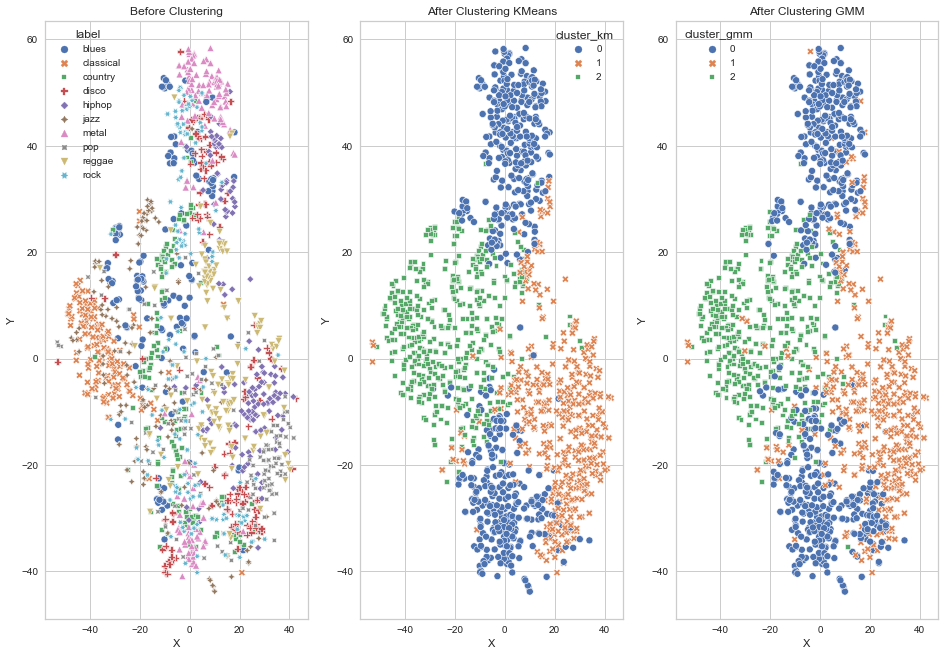

In [24]:
'''Visualize the scatter plot for original, 
K-means and GMM labels to compare the effect of models'''

fix, axes = plt.subplots(1,3, figsize=(16,11))

sns.scatterplot(ax=axes[0], x='X', y='Y', hue='label', style='label', palette='deep', data=tsne_df1)
axes[0].set_title('Before Clustering')

sns.scatterplot(ax=axes[1], x='X', y='Y', hue='cluster_km', style='cluster_km', palette='deep', data=tsne_df2)
axes[1].set_title('After Clustering KMeans')

sns.scatterplot(ax=axes[2], x='X', y='Y', hue='cluster_gmm', style='cluster_gmm', palette='deep', data=tsne_df2)
axes[2].set_title('After Clustering GMM')

plt.rc('legend')
plt.show()

In [25]:
# Save files
import pickle

# List of Inertia scores
with open('sum_distance.pkl', 'wb') as pickle_out:
    pickle.dump(sum_distances, pickle_out)
    
# List of Silhouette scores
with open('silhouette.pkl', 'wb') as pickle_out:
    pickle.dump(silhouette, pickle_out)
    
# Save BIC score dataframe into a csv file
bic_score.to_csv("bic_score.csv", index = False)